In [1]:
import numpy as np
import matplotlib.pyplot as plt
import config as cf
import data_loader as dl
from scipy.stats import poisson, chi2

[10:59:31] INFO     Configuration file loaded from:                                                    ]8;id=533005;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=747371;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#28\28]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway             
                    /trigger/scripts/../configs/default_config_vd.yaml                                             

           INFO     Default config file is:                                                            ]8;id=395170;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=664439;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#32\32]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway             
                    /trigger/scripts/../configs/default_config_vd.yaml                                             

           INFO     Loaded detector coordinates from file:                                            ]8;id=720065;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=276473;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#149\149]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/mywa              
                    y/trigger/scripts/../aux_data/detector_coordinates/pdpos_vd1x8x14v5.dat                        

           INFO     SN time profile loaded from ../aux_data/TimeProfile.root                     ]8;id=743478;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/data_loader.py\data_loader.py]8;;\:]8;id=292732;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/data_loader.py#671\671]8;;\

Total sum: 0.9984137845968193


/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_39899/3277947832.py:51: RuntimeWarning: invalid value encountered in divide
  to_max_pearson = s**2 / t
/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_39899/3277947832.py:56: RuntimeWarning: invalid value encountered in divide
  to_max_cash = - s + (s + k*t) * np.log(1 + s/(k*t))


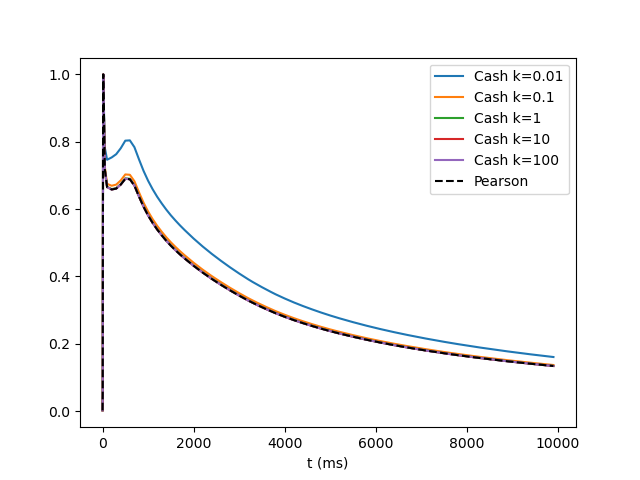

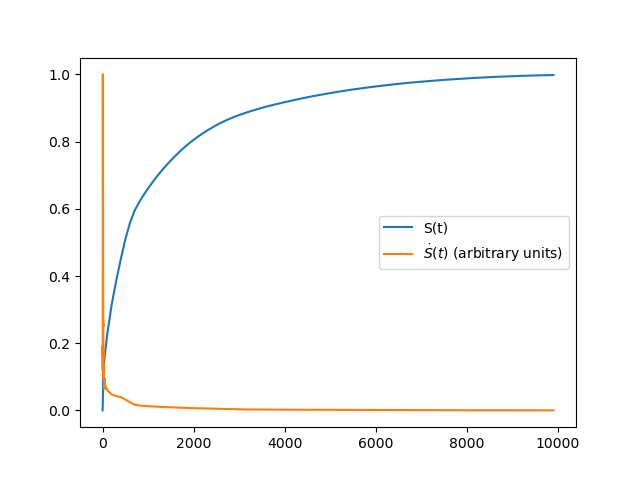

In [8]:
%matplotlib widget
# Load the config 
config_path = '../configs/default_config_vd.yaml'
config = cf.Configurator.from_file(config_path)

# Load the time profile histogram
data_loader = dl.DataLoader(config)
time_profile_x, time_profile_y = data_loader.load_time_profile()
t, sdot = time_profile_x, time_profile_y

#print(t)

# Shift t to the center of the time interval
#t = t + 0.5 * (t[1] - t[0])

# Compute the numerical integral I(t) = \int_0^t I(t') dt'
diff = np.diff(t)
# Note that this integral should add up to 1, and it does. This means
# however that sdot is not given as an event density, and we must divide by the time interval
s = np.cumsum(sdot)
print(f'Total sum: {np.sum(sdot)}')
sdot = sdot / diff
# The first entry of the integral should be 0, correspoding to the leftmost edge of the "bin"
# We can shave off the last entry as it will be irrelevant
s = np.insert(s, 0, 0)
s = s[:-1]
t = t[:-1]

#print(len(s), len(sdot), len(t))

# Finally, we can scale by a total number of "events" (i.e., clusters in a bin per ms)
scale = 1
sdot = sdot * scale
s = s * scale

# Plot the time profile
plt.figure()
plt.plot(t, s, label='S(t)')
plt.plot(t, sdot / np.max(sdot), label=r'$\dot{S}(t)$ (arbitrary units)')
plt.legend()

# # The equation to solve...
# lhs = 2 * sdot * t - s
# plt.figure()
# plt.plot(t, lhs)
# plt.axhline(0, color='black', linestyle='--')

# # The quantity to maximize is
k = 100
plt.figure()
to_max_pearson = s**2 / t
to_max_pearson = to_max_pearson / np.nanmax(to_max_pearson)
# The lowest rate we can have (per ms) is ~1e-2 (10 per second)
krange = [1e-2, 1e-1, 1, 10, 100]
for k in krange:
    to_max_cash = - s + (s + k*t) * np.log(1 + s/(k*t))
    to_max_cash  = to_max_cash / np.nanmax(to_max_cash)
    plt.plot(t, to_max_cash, label=f'Cash k={k}')

plt.plot(t, to_max_pearson, label='Pearson', linestyle='--', color='black')
plt.legend()
plt.xlabel('t (ms)')

plt.show()

/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_39899/1669463385.py:4: RuntimeWarning: invalid value encountered in divide
  pval = chi2.sf(s**2/(k*t), dof)  # = 1 - chi2.cdf(s**2/t, dof)


(0.0, 1000.0)

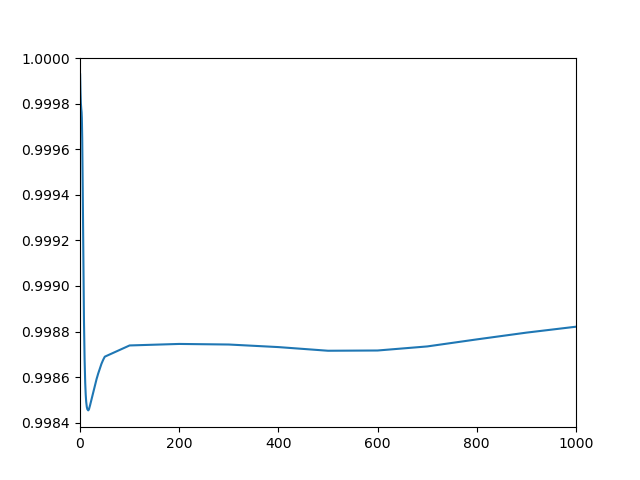

In [4]:
# Actually, we want to minimise the p-value! 
dof = 1
k = 200
pval = chi2.sf(s**2/(k*t), dof)  # = 1 - chi2.cdf(s**2/t, dof)

plt.figure()
plt.plot(t, pval)
plt.xlim(0, 1000)

Llr peaks at 0.0


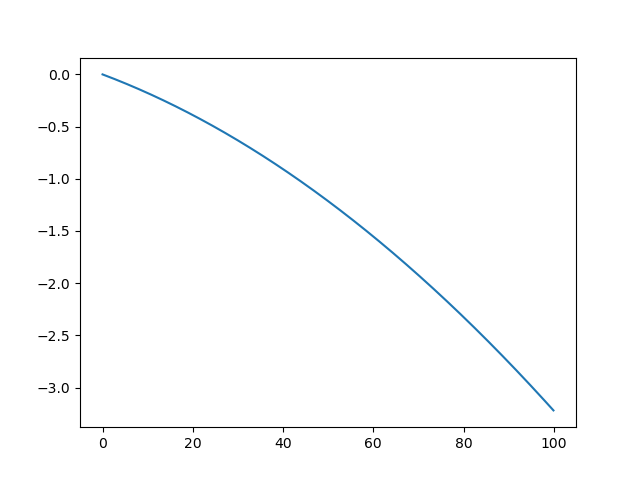

In [5]:
# Other bullshit

n = 6145
nprime = np.arange(0, 100, 0.1)
N = n + nprime

k = n - 50

# Log likelihood ratio
llr = -2 * (-k * np.log(1 + nprime/n) + nprime)
print(f"Llr peaks at {nprime[np.argmax(llr)]}")

plt.figure()
plt.plot(nprime, llr)
plt.show()

ftr_0 = 3.858024691358025e-07


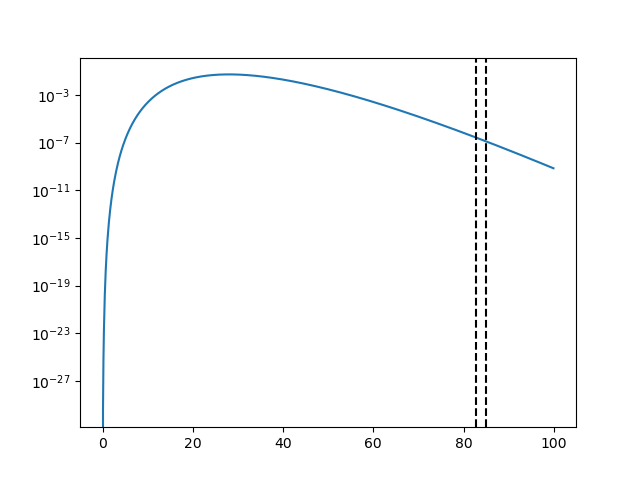

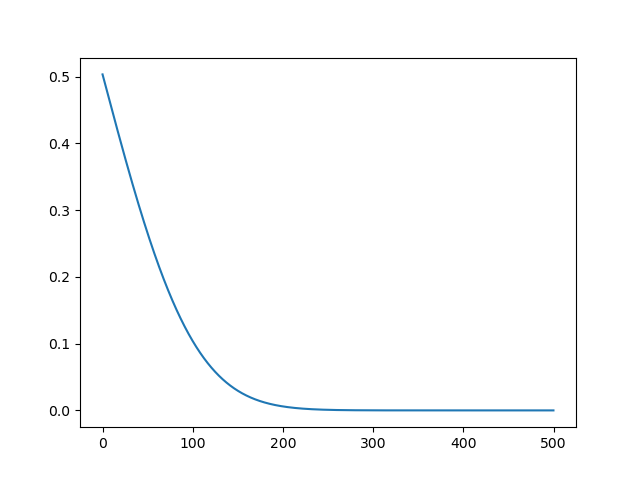

In [6]:
# More bullshit

df = 30
chi2_stat = np.arange(0, 100, 0.1)

ftr_0 = 1 / 30 / 24 / 60 / 60
print(f'ftr_0 = {ftr_0}')
ftr_1 = 2 * ftr_0 

chi2_pdf = chi2.pdf(chi2_stat, df)
pval = chi2.sf(chi2_stat, df) # Survival function, i.e., 1 - CDF, but with better numerical properties

plt.figure()
plt.plot(chi2_stat, chi2_pdf)
plt.axvline(chi2.isf(ftr_0, df), color='black', linestyle='--')
plt.axvline(chi2.isf(ftr_1, df), color='black', linestyle='--')
plt.yscale('log')

# plt.figure()
# plt.plot(chi2_stat, pval)
# plt.axhline(ftr_0, color='black', linestyle='--')
# plt.axhline(ftr_1, color='black', linestyle='--')
# plt.yscale('log')

# How many SN bursts do we miss if we cut at k < n...
n = 6145
nprime = np.arange(0, 500, 0.1)
# Prob(k < n; lambda=n+nprime) = CDF(n; lambda=n+nprime)
pmiss = poisson.cdf(n, n + nprime)

plt.figure()
plt.plot(nprime, pmiss)